## Entwicklung der Seitenaufrufe bei Serlo

Ich würde gerne überprüfen, wie sich die Seitenaufrufe bei Serlo entwickeln (Steigen oder fallen sie? / Wie wirkt sich das neue Design auf die Seitenaufrufe aus?). Schauen wir uns die Seitenaufrufe bei Serlo seit dem 1.9.2020 an:

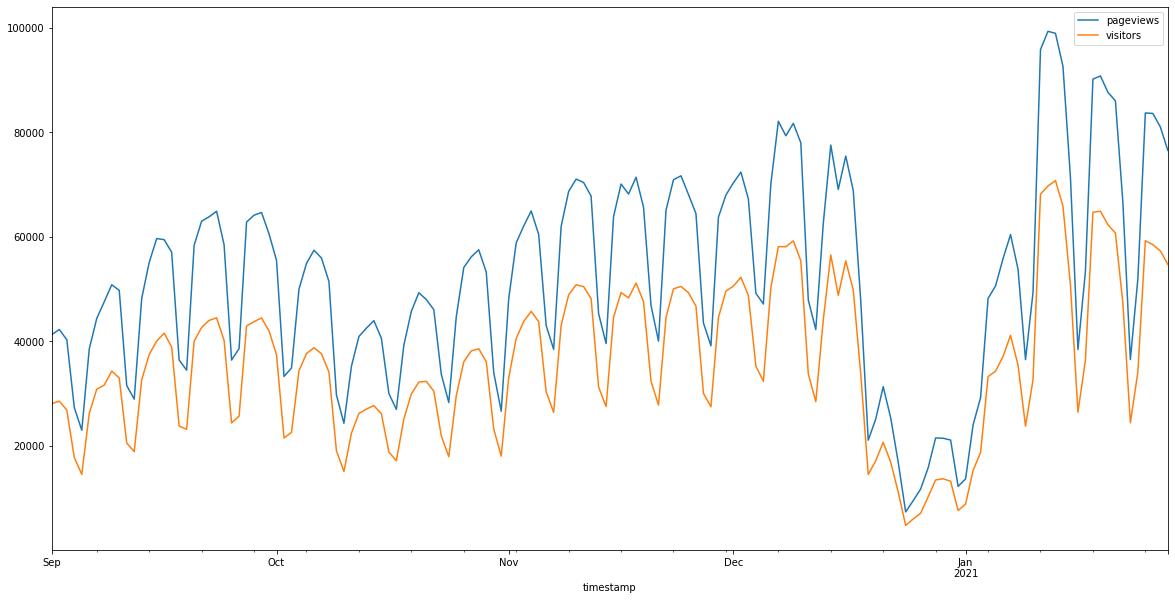

In [7]:
import pandas as pd
import json
import matplotlib.pyplot as plt

with open("de.serlo.org.json") as serlo_data:
    items = json.load(serlo_data)["histogram"]
    
    serlo =  pd.DataFrame({
        "timestamp": [ pd.Timestamp(item["date"]) for item in items ],
        "pageviews": [ item["pageviews"] for item in items ],
        "visitors": [ item["visitors"] for item in items ]
    }).set_index("timestamp")

serlo.plot(figsize=(20,10))
plt.show()

Jedoch verdecken saisonale und zeitliche Effekte den generellen Trend (Man sieht gut den Effekt des Wochenendes und den Einbruch um die Weihnachtsfeiertage. Auch sieht man, als Schüler:innen vermehrt im Homeschooling unterrichtet wurden). Um diese Effekte rauszurechnen könnte man die Seitenaufrufe bei Serlo mit denen einer anderen Plattform vergleichen, die denselben Effekten unterlegen ist. Hier können wir die Seitenaufrufe zu Schulthemen von Wikipedia-Artikeln heranziehen, weil sie denselben Effekten unterlegen sein sollten. Schauen wir uns die Seitenaufrufe des Artikels zum "Satz des Pythagoras" an:

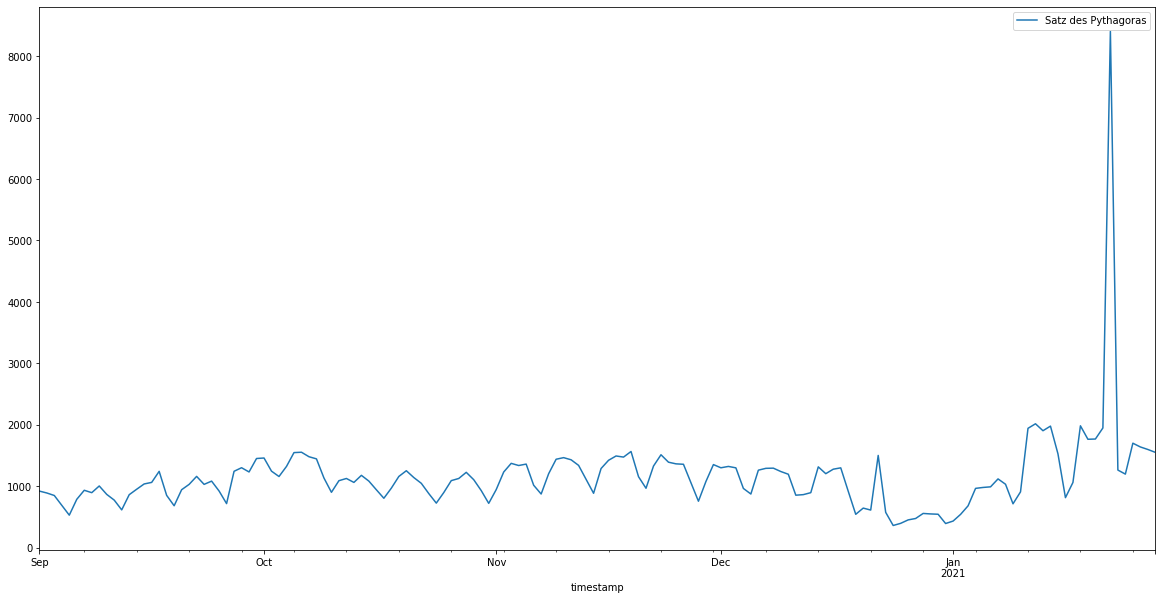

In [2]:
import requests
import pandas as pd

from datetime import date, timedelta

start_time = date(2020, 9, 1)
# end_time = date.today() - timedelta(days=1)
end_time = date(2021,1,28) 

def read_wikipedia_pageviews(title):
    user_agent = "MyJupyterEvaluations/1.0 (https://github.com/kulla/serlo-evaluations; https://de.wikibooks.org/wiki/Benutzer:Stephan_Kulla)"
    encoded_title = title.replace(" ", "_")
    url = """
        https://wikimedia.org/api/rest_v1/metrics/pageviews
        /per-article/de.wikipedia.org
        /all-access/user/%s/daily/%s/%s
    """ % (encoded_title, start_time.strftime("%Y%m%d"), end_time.strftime("%Y%m%d"))
    url = url.replace(" ", "").replace("\n", "")
    req = requests.get(url, headers={ "User-Agent": user_agent })
    
    items = req.json()["items"]
    
    result = pd.DataFrame({
        "timestamp": [ pd.Timestamp(item["timestamp"][:-2]) for item in items ],
        "views": [ item["views"] for item in items ]
    })
    result = result.set_index("timestamp").rename(columns={"views": title})
    return result

read_wikipedia_pageviews("Satz des Pythagoras").plot(figsize=(20,10))
plt.show()

Okay, es gibt outlier im Datensatz. Also rechnen wir sie raus, indem wir alle Datenpunkte mit Abweichung von mehr als 3 Standardabweichungen um den Mittelwert löschen:

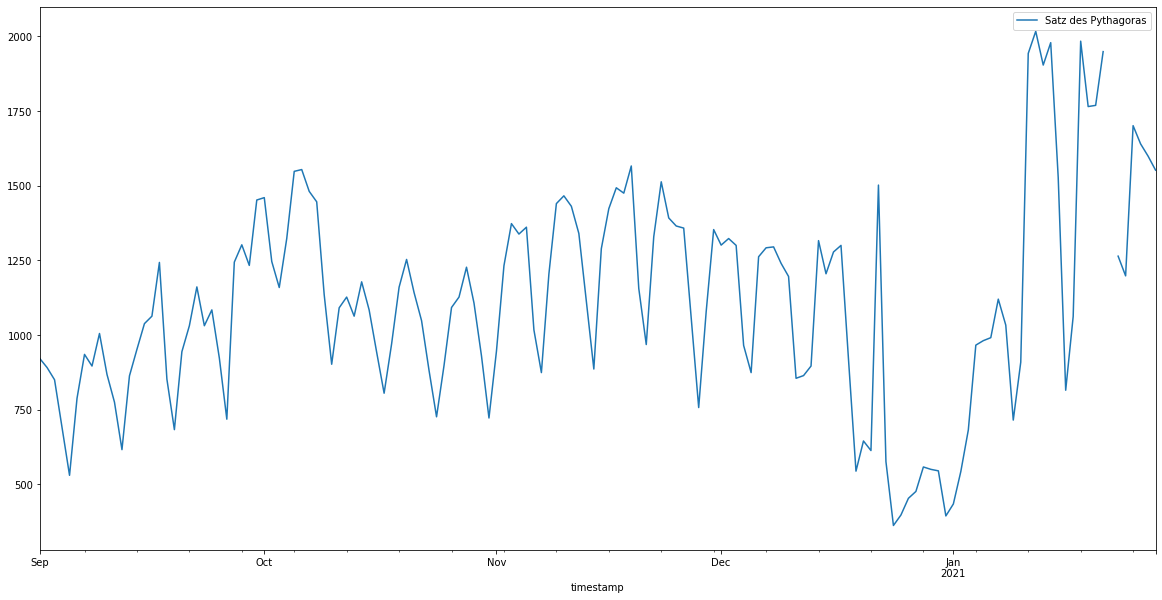

In [3]:
from scipy import stats

def remove_outliers(df):
    result = df.copy()
    result[stats.zscore(result) > 3] = None
    return result

remove_outliers(read_wikipedia_pageviews("Satz des Pythagoras")).plot(figsize=(20,10))
plt.show()

Wir sehen einen ähnlichen zeitlichen Verlauf wie bei den Seitenaufrufen auf Serlo. Für ein besseres Ergebnis nutzen wir nicht nur einen Wikipedia-Artikel, sondern mehrere und bilden jeweils einen Mittelwert der Seitenaufrufe:

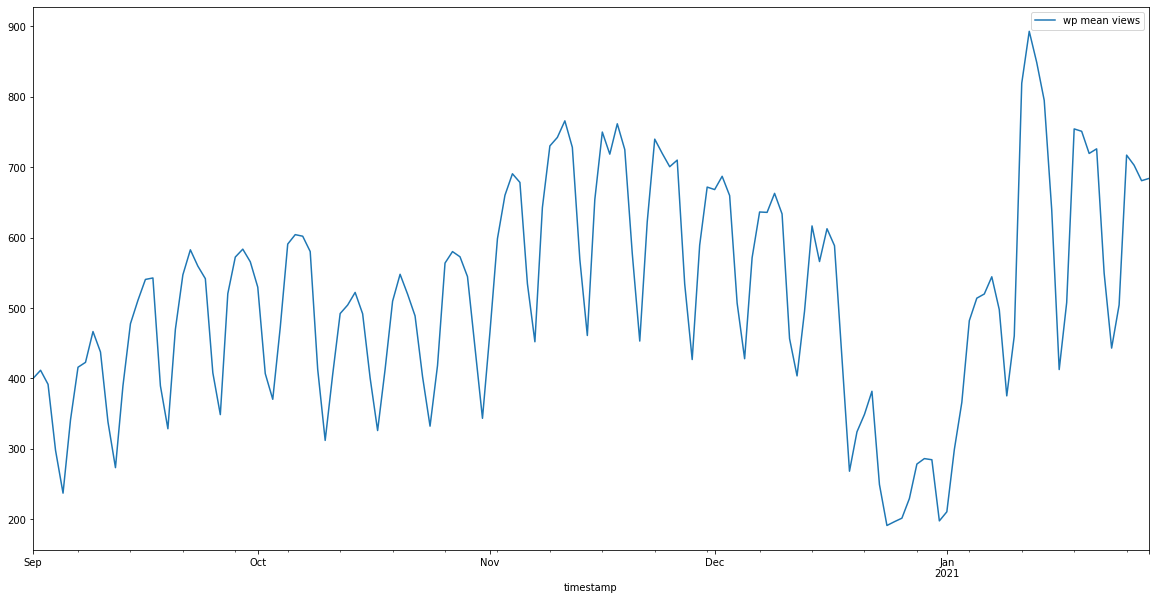

In [4]:
articles = [
    "Satz des Pythagoras",
    "Satz des Thales",
    "Ableitung",
    "Integralrechnung",
    "Potenz (Mathematik)",
    "Bruchrechnung",
    "Sinus und Kosinus",
    "Wurzel (Mathematik)",
    "Polynomdivision",
    "Quadratische Gleichung",
    "Binomische Formeln",
    "Flächeninhalt",
    "Proportionalität"
]


article_views = [remove_outliers(read_wikipedia_pageviews(a)) for a in articles]
wp = pd.concat(article_views, axis=1).mean(axis=1, skipna=True)
wp = pd.DataFrame(wp).rename(columns={0: "wp mean views"})

wp.plot(figsize=(20,10))
plt.show()

### @Jakob: Wie vergleiche ich beide Verläufe der Seitenaufrufe?

Mein Ansatz bisher: Ich bilde bei beiden Serien jeweils den [z-Score](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html) und vergleiche diese miteinander (in grün ist eingezeichnet, wann wir anstelle von 10% insgesamt 25% unser User:innen auf das neue Design schicken)

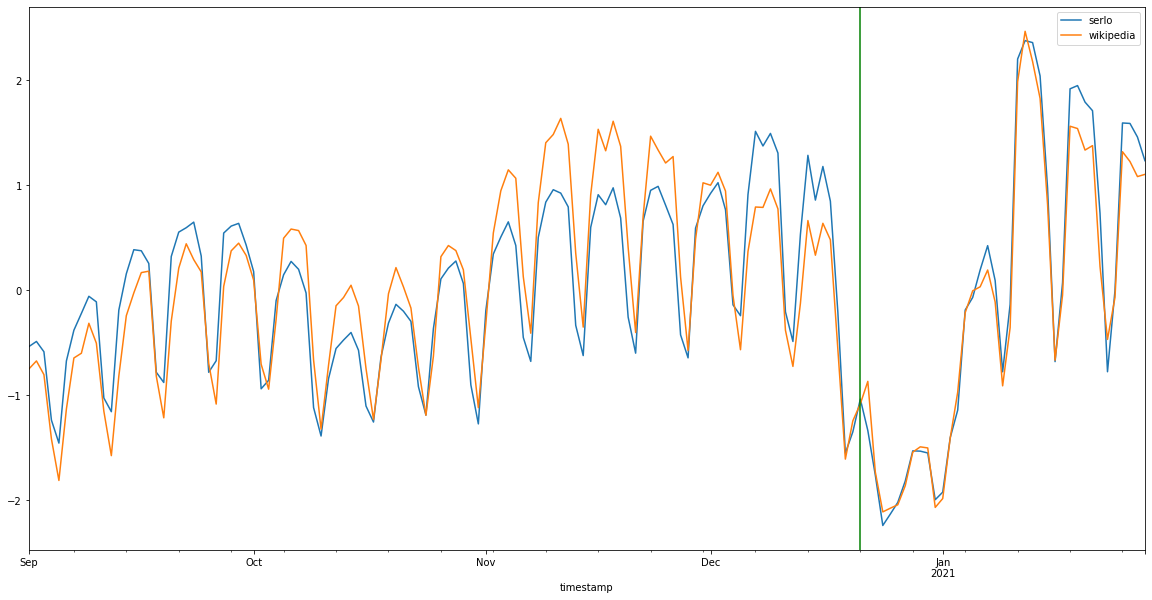

In [5]:
df = pd.concat([
    pd.DataFrame(stats.zscore(serlo["pageviews"])).rename(columns={0: "serlo"}),
    pd.DataFrame(stats.zscore(wp["wp mean views"])).rename(columns={0: "wikipedia"})
], axis=1)
df.index = serlo.index
df.plot(figsize=(20,10))
plt.axvline(pd.Timestamp("2020-12-21"), color="green")
plt.show()

Ist es richtig, dass wenn ich die Differenz des z-Scores bilde, ich einen guten Vergleichswert habe? Irgendwie sieht mir das noch nicht ganz richtig aus...

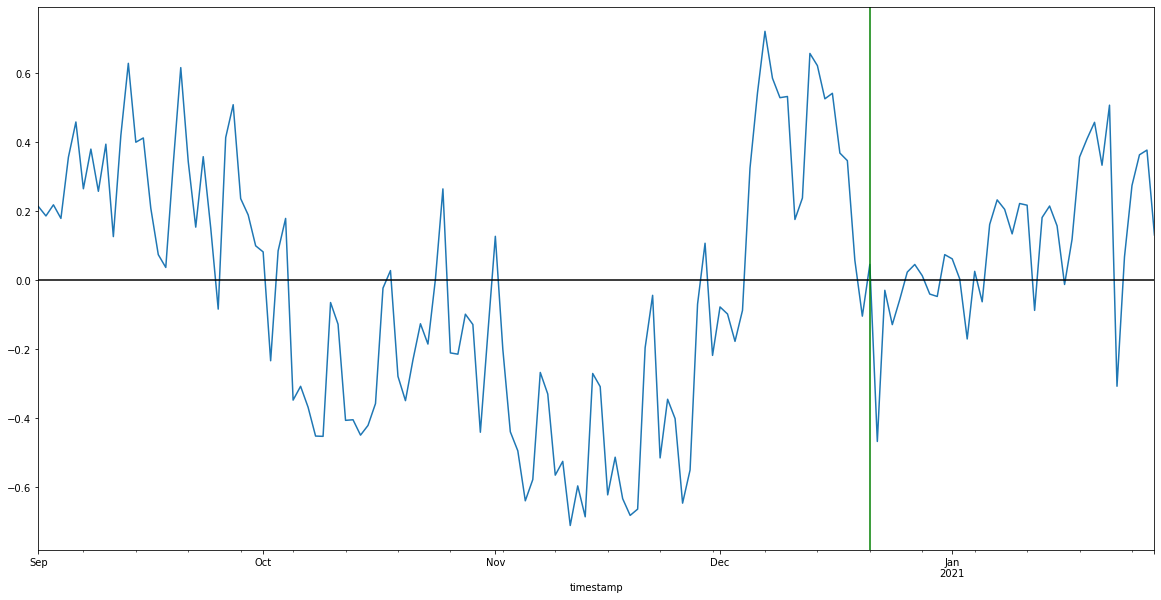

In [6]:
(df["serlo"] - df["wikipedia"]).plot(figsize=(20,10))
plt.axhline(0, color="black")
plt.axvline(pd.Timestamp("2020-12-21"), color="green")
plt.show()

Diese Differenz scheint mir noch sehr stark noise-behaftet zu sein... Wie gehe ich damit richtig um?!